### 比特幣使用ARMA

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/Bitcoin_sort.csv')
df.head()

,id,CoinDate,CoinOpen,CoinHigh,CoinLow,CoinClose,CoinVolume,CoinCap
0,937,2020/05/04,8895.74,8956.91,8645.02,8912.65,4.571880e+10,1.636545e+11
1,936,2020/05/05,8912.83,9062.41,8856.83,9003.07,4.314846e+10,1.653325e+11
2,935,2020/05/06,9007.44,9411.47,8966.71,9268.76,4.937189e+10,1.702296e+11
3,934,2020/05/07,9261.90,9992.66,9138.32,9951.52,6.111270e+10,1.827874e+11
4,933,2020/05/08,9936.16,9996.74,9767.17,9842.67,5.178075e+10,1.808049e+11


In [3]:
x_date=[]
for i in range(0,938,91):
    x_date.append(df['CoinDate'][i])


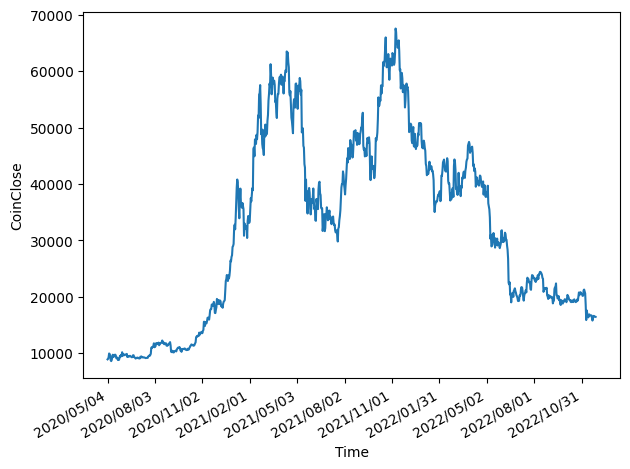

In [4]:
fig, ax = plt.subplots()

ax.plot(df['CoinClose'])
ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F01_peixeiro.png', dpi=300)

In [5]:
#使用 ADF 檢驗檢驗平穩性
#p值不顯著，表示不具有平穩性
ADF_result = adfuller(df['CoinClose'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.486996879940301
p-value: 0.5399337098655169


In [63]:
#因為原本資料不具有平穩性，所以需要進行一次微分，使資料具有平穩性。
CoinClose_diff = np.diff(df['CoinClose'], n=1) 

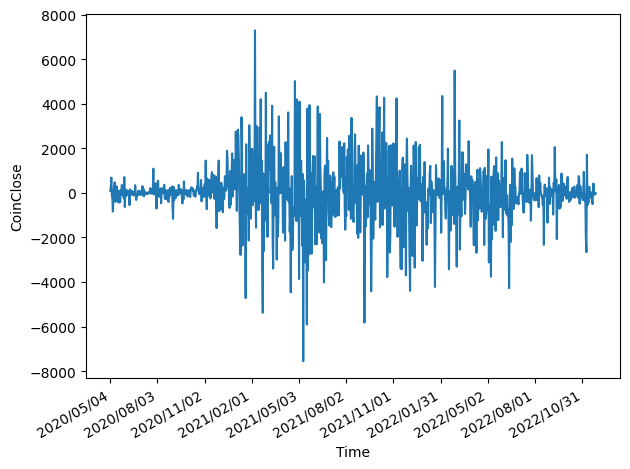

In [21]:
#可以用一次微分後的資料繪圖
fig, ax = plt.subplots()

ax.plot(CoinClose_diff)
ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)

In [22]:
#微分後p值小於0.05，表示一次微分後資料具有平穩性。
ADF_result = adfuller(CoinClose_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -31.50427486277576
p-value: 0.0


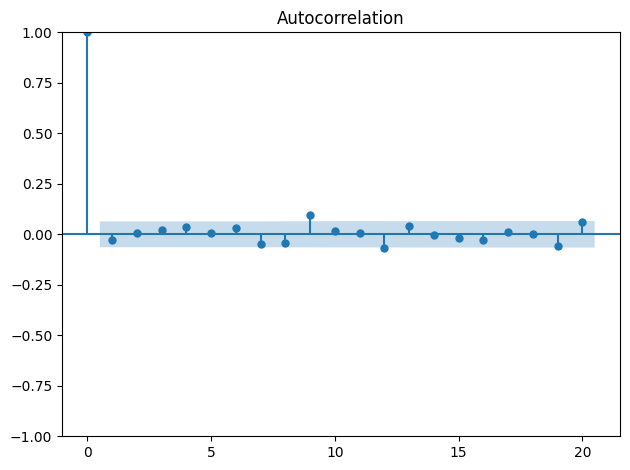

In [23]:
#繪製ACF圖，觀看是否在滯後n個值後具有顯著性。
#圖中顯示沒有任何值滯後n是顯著性
plot_acf(CoinClose_diff, lags=20);
plt.tight_layout()
plt.savefig('figures/CH05_F06_peixeiro.png', dpi=300)

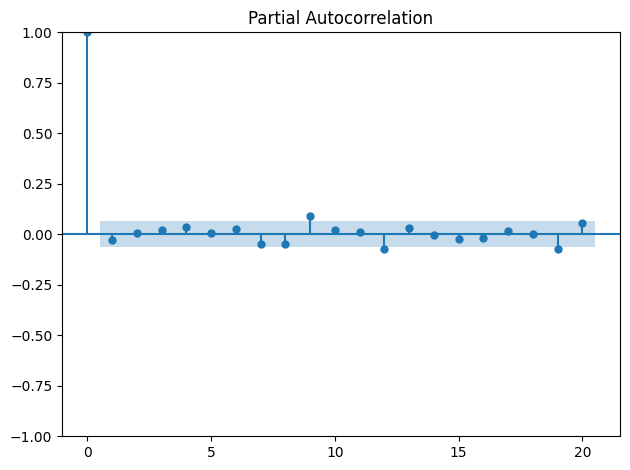

In [25]:
plot_pacf(CoinClose_diff, lags=20);
plt.tight_layout()
plt.savefig('figures/CH05_F07_peixeiro.png', dpi=300)

In [26]:
df_diff = pd.DataFrame({'CoinClose_diff': CoinClose_diff})

train = df_diff[:int(len(df_diff)*0.8)]
test = df_diff[int(len(df_diff)*0.8):]

print(len(train))
print(len(test))

749
188


Text(24.0, 0.5, 'CoinClose')

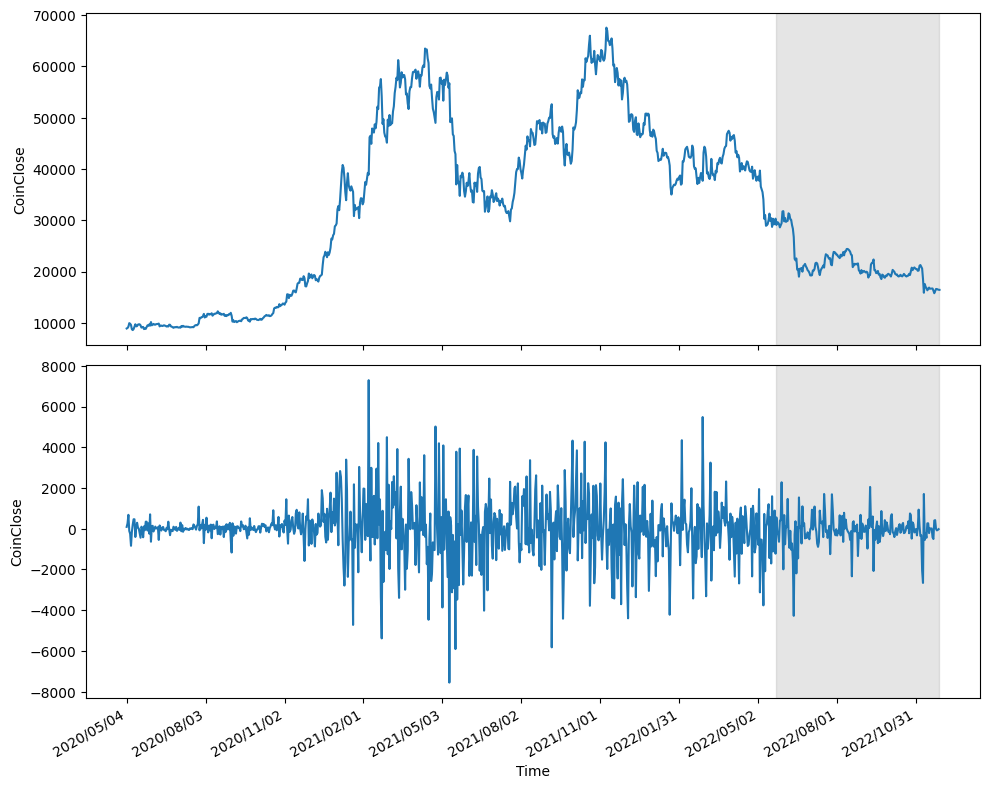

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['CoinClose'])
ax1.set_xlabel('Time')
ax1.set_ylabel('CoinClose')
ax1.axvspan(749, 937, color='#808080', alpha=0.2)

ax2.plot(df_diff['CoinClose_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('CoinClose')
ax2.axvspan(748, 936, color='#808080', alpha=0.2)

plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F17_peixeiro.png', dpi=300)


ax.plot(df['CoinClose'])
ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

In [30]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [31]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [32]:
result_df = optimize_ARMA(train['CoinClose_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 2)",13059.360275
1,"(0, 0)",13059.753786
2,"(1, 0)",13060.747362
3,"(0, 1)",13060.763958
4,"(2, 3)",13061.387980
5,"(2, 0)",13062.744504
6,"(1, 1)",13062.753715
7,"(0, 2)",13062.769940
8,"(3, 3)",13063.193951
9,"(1, 2)",13063.953803


In [34]:
model = SARIMAX(train['CoinClose_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:         CoinClose_diff   No. Observations:                  749
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -6524.680
Date:                Sun, 08 Jan 2023   AIC                          13059.360
Time:                        16:44:33   BIC                          13082.454
Sample:                             0   HQIC                         13068.259
                                - 749                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8229      0.030     27.790      0.000       0.765       0.881
ar.L2         -0.9488      0.027    -35.288      0.000      -1.002      -0.896
ma.L1         -0.8564      0.028    -30.834      0.0

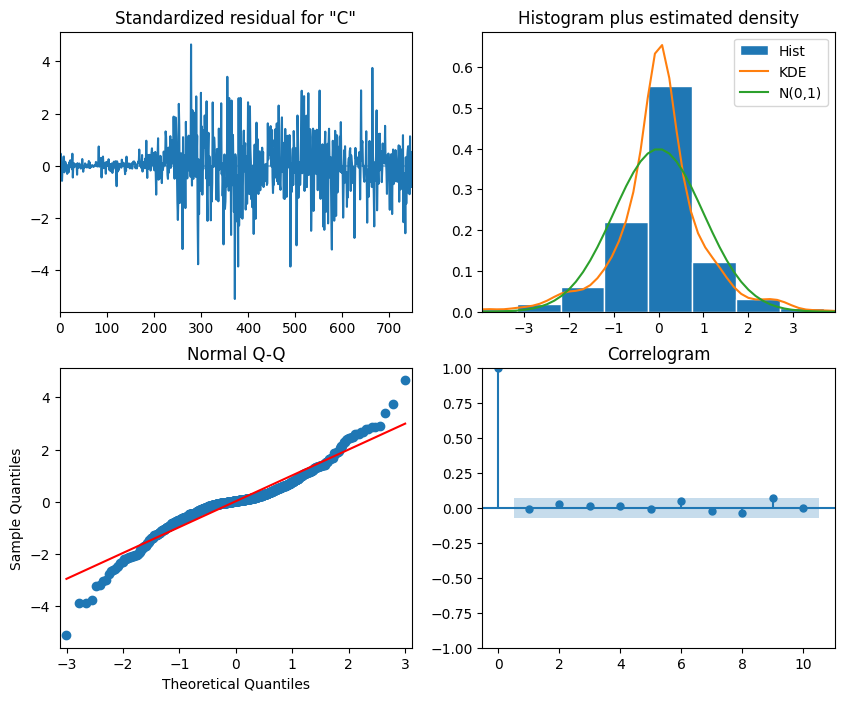

In [35]:
model_fit.plot_diagnostics(figsize=(10, 8));
# plt.savefig('figures/CH06_F19_peixeiro.png', dpi=300)

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


##  Forecasting bandwidth usage

In [40]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [41]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,CoinClose_diff,pred_mean,pred_last_value,pred_ARMA
749,556.68,26.950948,-1224.81,-62.636670
750,-93.23,26.950948,-1224.81,-51.605059
751,-295.14,27.496285,-93.23,3.270859
752,-639.65,27.496285,-93.23,69.548266
753,395.92,26.181833,-639.65,84.026981


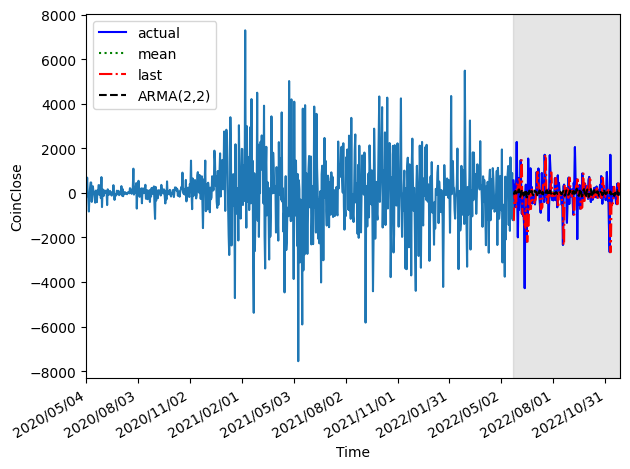

In [42]:
fig, ax = plt.subplots()

ax.plot(df_diff['CoinClose_diff'])
ax.plot(test['CoinClose_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

ax.axvspan(748, 936, color='#808080', alpha=0.2)

ax.set_xlim(748, 936)


plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F20_peixeiro.png', dpi=300)



In [54]:
mse_mean = mean_squared_error(test['CoinClose_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['CoinClose_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['CoinClose_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

580105.180325315 982998.7690159574 594091.9113915189


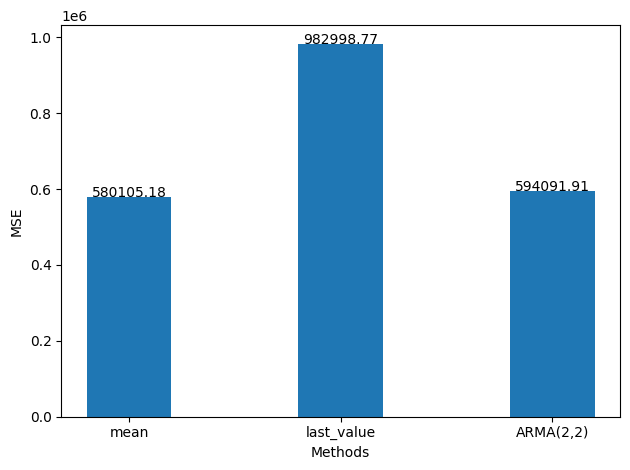

In [55]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
# ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.35, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [67]:

df['pred_CoinClose'] = pd.Series()
df['pred_CoinClose'][750:] = df['CoinClose'].iloc[750] + test['pred_ARMA'].cumsum()



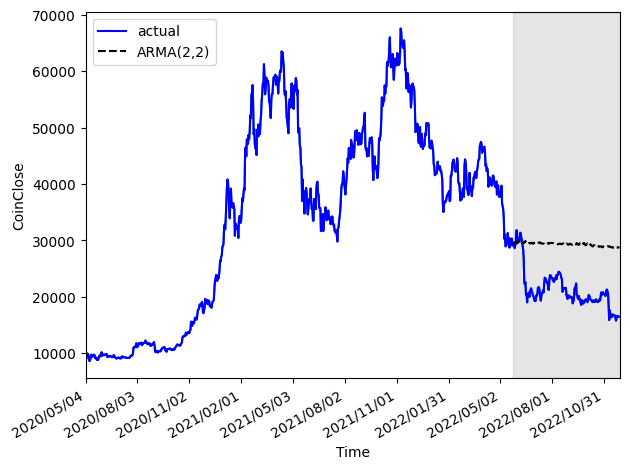

In [69]:
fig, ax = plt.subplots()

ax.plot(df['CoinClose'])
ax.plot(df['CoinClose'], 'b-', label='actual')
ax.plot(df['pred_CoinClose'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('CoinClose')

ax.axvspan(750, 938, color='#808080', alpha=0.2)

ax.set_xlim(750, 938)


plt.xticks(np.arange(0,938,91),x_date)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F21_peixeiro.png', dpi=300)

In [70]:
mae_ARMA_undiff = mean_absolute_error(df['CoinClose'][750:], df['pred_CoinClose'][750:])

print(mae_ARMA_undiff)

8068.630680095311
